# Overview

The growth of e-commerce has been one of the most significant trends in business over the past decade. Advances in mobile technology, logistics, and delivery has contributed to this explosion in growth. Product reviews are an essential component of e-commerce, and they play a significant role in shaping consumer behavior. There are now many platforms ranging from social media to online marketplaces that allow customers to easily provide feedback for products. Companies can use sentiment classification to analyze customer feedback and identify areas where customers are dissatisfied or delighted with their products or services. This can help businesses improve their products and customer service, and ultimately increase customer satisfaction and loyalty.

# Buisness Problem

Good Ears a new audio company is planning to launch their first headphone through Amazon. We are tasked to analyze the headphone market on Amazon to see if any insights can be found to assist the marketing department.

Product reviews can provide businesses with a better understanding of customer feedback and preferences. By analyzing product reviews, businesses can gain insights into what customers like and dislike about their products, identify areas for improvement, and develop strategies to enhance customer satisfaction and loyalty.


# Methodology

Due to the massive amounts of reviews avaliable, it is too time consuming to examine each and every data. Topic modeling and sentiment analysis are two powerful techniques used in natural language processing and machine learning to analyze text data and gain insights into customer feedback and preferences.

LDA assumes that each document is a mixture of multiple topics and that each word in the document is associated with a particular topic. The model then attempts to identify the most likely topic distribution for each document and the most likely word distribution for each topic. I will be using Gensim's library to conduct LDA topic modeling.

First I will validate the relationship between star ratings and sentiment with VADER. Then I will proceed to test out different methods of vectorizers and classification algorithms to find the best model that can predict whether a review is positive or negative.

# Data Understanding

Data for this project was obtained from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/ which includes a large-scale collection of customer reviews of products sold on Amazon.Each review includes the review text, as well as additional metadata such as the product ID, reviewer ID, rating, and helpfulness votes.

Original dataset contained around 6.7 million reviews of products from the electronics category. For the purpose of this project I have subsetted dataset to include only headphone and earphone products with 200 or more reviews. Resulting in a collection of 189,482 reviews from June, 2000 to October 2018. 

# Data Preperation

In [2]:
# Importing neccesary libraries
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

import gzip
from nltk import word_tokenize

from nltk.sentiment import SentimentIntensityAnalyzer

import re
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


from sklearn.feature_extraction.text import CountVectorizer

import gensim
import gensim.corpora as corpora

from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from ast import literal_eval

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [54]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { max-width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.output_area { max-width:100% !important; }</style>"))
display(HTML("<style>.input_area { max-width:100% !important; }</style>"))

# Data Exploration

## EDA

In [99]:
df = pd.read_csv('data/headphone_reviews.csv')

C:\Users\PC\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (1,15,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [100]:
df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,...,feature,rank,also_view,main_cat,similar_item,date,price,imageURL,imageURLHighRes,details
0,5.0,NaN,True,"02 22, 2015",A38RQFVQ1AKJQQ,4126895493,{'Color:': ' Blue W/Mic'},George Walker,Great headphones. It's just the cord is too sh...,Five Stars,...,['Adjustable headband allows you to create a c...,"['>#316,475 in Cell Phones & Accessories (See ...","['B019PO1ZRI', 'B00W87LKXE', 'B019PO1ZNC', 'B0...",Musical Instruments,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$7.99,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
1,5.0,NaN,True,"05 8, 2017",A299MRB9O6GWDE,4126895493,{'Color:': ' Blue Zebra W/Mic'},Carolyn B,Really like these headphone. Wanted something...,Officewear,...,['Adjustable headband allows you to create a c...,"['>#316,475 in Cell Phones & Accessories (See ...","['B019PO1ZRI', 'B00W87LKXE', 'B019PO1ZNC', 'B0...",Musical Instruments,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$7.99,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
2,1.0,NaN,True,"11 5, 2016",A3ACFC6DQQLIQT,4126895493,{'Color:': ' Blue W/Mic'},MK,Wire to headphone broke off in less than a mon...,For the money they are fine. Just hope they ho...,...,['Adjustable headband allows you to create a c...,"['>#316,475 in Cell Phones & Accessories (See ...","['B019PO1ZRI', 'B00W87LKXE', 'B019PO1ZNC', 'B0...",Musical Instruments,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$7.99,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
3,3.0,NaN,True,"09 24, 2016",A36BC0YFDBNB5X,4126895493,{'Color:': ' Green'},bigboy,Very good,Three Stars,...,['Adjustable headband allows you to create a c...,"['>#316,475 in Cell Phones & Accessories (See ...","['B019PO1ZRI', 'B00W87LKXE', 'B019PO1ZNC', 'B0...",Musical Instruments,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$7.99,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN
4,1.0,NaN,True,"07 17, 2016",A212PQ0HQPNNWM,4126895493,{'Color:': ' Violet Purple'},Kelly Hales,Currently returning this product because the s...,Currently returning this product because the s...,...,['Adjustable headband allows you to create a c...,"['>#316,475 in Cell Phones & Accessories (See ...","['B019PO1ZRI', 'B00W87LKXE', 'B019PO1ZNC', 'B0...",Musical Instruments,"class=""a-bordered a-horizontal-stripes a-spa...",NaN,$7.99,['https://images-na.ssl-images-amazon.com/imag...,['https://images-na.ssl-images-amazon.com/imag...,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471228 entries, 0 to 471227
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   overall          471228 non-null  float64
 1   vote             65135 non-null   object 
 2   verified         471228 non-null  bool   
 3   reviewTime       471228 non-null  object 
 4   reviewerID       471228 non-null  object 
 5   asin             471228 non-null  object 
 6   style            294015 non-null  object 
 7   reviewerName     471143 non-null  object 
 8   reviewText       471167 non-null  object 
 9   summary          471147 non-null  object 
 10  unixReviewTime   471228 non-null  int64  
 11  image            9026 non-null    object 
 12  category         471228 non-null  object 
 13  tech1            24660 non-null   object 
 14  description      471228 non-null  object 
 15  fit              22 non-null      object 
 16  title            471228 non-null  obje

In [101]:
# Checking for duplicate rows
df.astype(str).duplicated().sum()

36841

In [102]:
# Dropping duplicates
df = df.loc[df.astype(str).drop_duplicates().index]

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 434387 entries, 0 to 471227
Data columns (total 30 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   overall          434387 non-null  float64
 1   vote             58949 non-null   object 
 2   verified         434387 non-null  bool   
 3   reviewTime       434387 non-null  object 
 4   reviewerID       434387 non-null  object 
 5   asin             434387 non-null  object 
 6   style            268880 non-null  object 
 7   reviewerName     434312 non-null  object 
 8   reviewText       434328 non-null  object 
 9   summary          434307 non-null  object 
 10  unixReviewTime   434387 non-null  int64  
 11  image            8803 non-null    object 
 12  category         434387 non-null  object 
 13  tech1            24192 non-null   object 
 14  description      434387 non-null  object 
 15  fit              22 non-null      object 
 16  title            434387 non-null  obje

In [104]:
# Checking for null values, focusing on reviewText
df.isna().sum()

overall                 0
vote               375438
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              165507
reviewerName           75
reviewText             59
summary                80
unixReviewTime          0
image              425584
category                0
tech1              410195
description             0
fit                434365
title                   0
also_buy                0
tech2              432645
brand                 356
feature                 0
rank                    0
also_view               0
main_cat               73
similar_item       106986
date               141836
price              177433
imageURL                0
imageURLHighRes         0
details                49
dtype: int64

In [105]:
# Dropping rows with null values in reviewText
df.dropna(subset = ['reviewText'], inplace = True)

In [106]:
df.isna().sum()

overall                 0
vote               375385
verified                0
reviewTime              0
reviewerID              0
asin                    0
style              165480
reviewerName           75
reviewText              0
summary                79
unixReviewTime          0
image              425538
category                0
tech1              410141
description             0
fit                434306
title                   0
also_buy                0
tech2              432586
brand                 356
feature                 0
rank                    0
also_view               0
main_cat               73
similar_item       106970
date               141815
price              177403
imageURL                0
imageURLHighRes         0
details                49
dtype: int64

### Subsetting Data

In [108]:
# Dropping other features with many null values. Also drop features that may not be needed.
to_drop = ['vote', 'style', 'image', 'tech1', 'fit', 'tech2', 'similar_item', 'date', 
           'price', 'reviewerID', 'reviewerName', 'unixReviewTime', 'category', 'rank', 
           'main_cat', 'imageURL', 'imageURLHighRes', 'details']
df = df.drop(columns = to_drop)

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434328 entries, 0 to 434327
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   overall      434328 non-null  float64
 1   verified     434328 non-null  bool   
 2   reviewTime   434328 non-null  object 
 3   asin         434328 non-null  object 
 4   reviewText   434328 non-null  object 
 5   summary      434249 non-null  object 
 6   description  434328 non-null  object 
 7   title        434328 non-null  object 
 8   also_buy     434328 non-null  object 
 9   brand        433972 non-null  object 
 10  feature      434328 non-null  object 
 11  also_view    434328 non-null  object 
dtypes: bool(1), float64(1), object(10)
memory usage: 36.9+ MB


To reduce the size of data, I will only keep asins that have over 200 reviews.

In [110]:
counts = df['asin'].value_counts()

In [111]:
df = df[df['asin'].isin(counts[counts > 200].index)]

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189482 entries, 451 to 430674
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   overall      189482 non-null  float64
 1   verified     189482 non-null  bool   
 2   reviewTime   189482 non-null  object 
 3   asin         189482 non-null  object 
 4   reviewText   189482 non-null  object 
 5   summary      189446 non-null  object 
 6   description  189482 non-null  object 
 7   title        189482 non-null  object 
 8   also_buy     189482 non-null  object 
 9   brand        189482 non-null  object 
 10  feature      189482 non-null  object 
 11  also_view    189482 non-null  object 
dtypes: bool(1), float64(1), object(10)
memory usage: 17.5+ MB


In [113]:
df = df.reset_index(drop = True)

In [114]:
# df.to_csv('data/reviews_subset.csv', index = False)

In [3]:
df = pd.read_csv('data/reviews_subset.csv')

### Review Ratings

Product reviews are represented by overall feature, ranging from 1 to 5.

In [31]:
# Distribution of star ratings
df.overall.value_counts(normalize = True)

5.0    0.595386
4.0    0.190778
3.0    0.093159
1.0    0.062961
2.0    0.057715
Name: overall, dtype: float64

In [32]:
star_count = df.overall.value_counts()

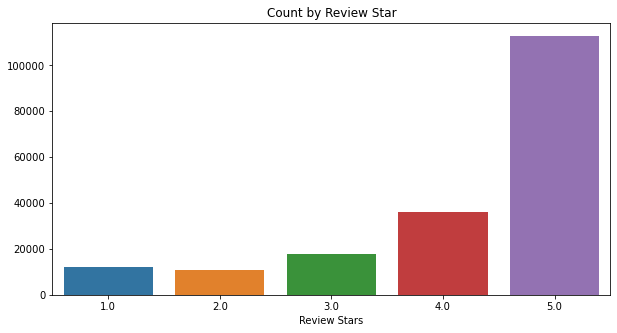

In [30]:
fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x = star_count.index, y = star_count.values, ax = ax)
ax.set_xlabel('Review Stars')
ax.set_title('Count by Review Star');

Majority of product reviews are 5 star, around 60%. This will be an imbalanced dataset for classification.

### Examining other features

In [180]:
# Examining date range of reviews
df.reviewTime = pd.to_datetime(df.reviewTime)
print(df.reviewTime.min())
print(df.reviewTime.max())

2000-06-29 00:00:00
2018-10-01 00:00:00


In [178]:
len(df.asin.value_counts())

395

In [179]:
len(df.brand.value_counts())

169

Dataset contains a total of 395 unique products and 169 unique brands dating from June, 2000 to October, 2018.

In [24]:
df.verified.value_counts(normalize = True)

True     0.891399
False    0.108601
Name: verified, dtype: float64

Around 90% of reviews have been verified purchases.

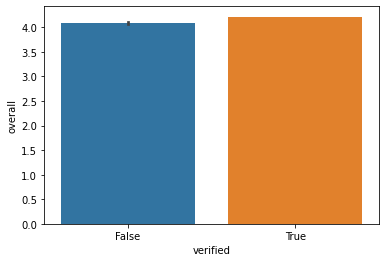

In [177]:
sns.barplot(data = df, x = 'verified', y = 'overall');

No major difference between average star rating of verified vs non verified purchase reviews.

In [189]:
# Find top 5 brands with the most reviews
top5brand = df.brand.value_counts().head(5)

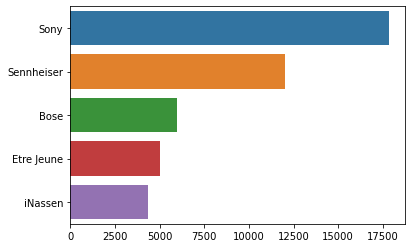

In [193]:
sns.barplot(x = top5brand.values, y = top5brand.index, orient = 'h');

In [201]:
# calculate average rating for top 5 most reviewed brands
top5 = df[df.brand.isin(top5brand.index)]
top5_rating = top5.groupby('brand')['overall'].mean().sort_values(ascending = False)
top5_rating

brand
Etre Jeune    4.466402
Bose          4.374181
iNassen       4.328222
Sennheiser    4.249293
Sony          4.207768
Name: overall, dtype: float64

In [202]:
top5_rating.mean()

4.325173061301141

In [194]:
# Find bottom 5 brands with the least reviews
bot5brand = df.brand.value_counts().tail(5)

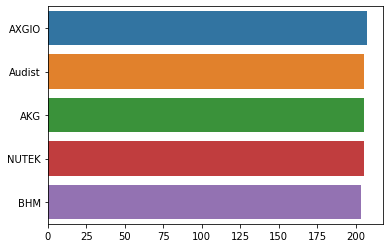

In [195]:
sns.barplot(x = bot5brand.values, y = bot5brand.index, orient = 'h');

In [205]:
# calculate average rating
bot5 = df[df.brand.isin(bot5brand.index)]
bot5_rating = bot5.groupby('brand')['overall'].mean().sort_values(ascending = False)
bot5_rating

brand
AKG       4.380488
Audist    4.141463
BHM       4.123153
AXGIO     3.956522
NUTEK     3.478049
Name: overall, dtype: float64

In [206]:
bot5_rating.mean()

4.015934889698007

Average rating for the top 5 most reviewed brand is higher than average rating for least reviewed brand. 

In [210]:
# Finding average rating for top 5 most reviewed asin
top5asin = df.asin.value_counts().head(5)
asin_top5 = df[df.asin.isin(top5asin.index)]
asin_top5_rating = asin_top5.groupby('asin')['overall'].mean().sort_values(ascending = False)
asin_top5_rating

asin
B007FHX9OK    4.458315
B00BN0N0LW    4.263361
B004WODP20    4.262584
B00LP6CFEC    4.085190
B00STP86CW    4.076492
Name: overall, dtype: float64

In [211]:
asin_top5_rating.mean()

4.229188294447225

In [212]:
# Finding average rating for 5 least reviewed asin
bot5asin = df.asin.value_counts().tail(5)
asin_bot5 = df[df.asin.isin(bot5asin.index)]
asin_bot5_rating = asin_bot5.groupby('asin')['overall'].mean().sort_values(ascending = False)
asin_bot5_rating

asin
B0006DPMU4    4.393035
B00PVT4T7K    4.141463
B01F5S4BEC    4.123153
B014LMX5AY    4.121951
B0014II9F0    3.478049
Name: overall, dtype: float64

In [213]:
asin_bot5_rating.mean()

4.051530189972879

Same can be seen with the most and least reviewed products average ratings are higher as reviews increase.

## Sentiment Validation of Star Ratings

In order to reduce this problem to a binary classification. I will ultilize NLTK's VADER library, which is designed to provide a sentiment intensity score for a given text, to validate positive sentiment with high ratings and negative sentiment with low ratings. Vader uses a lexicon-based approach, where it matches words and phrases in the text to a pre-defined set of positive and negative words, along with intensifiers and negators.

In [69]:
# initialize SIA
sia = SentimentIntensityAnalyzer()

In [70]:
# Example text
df.reviewText[0]

'Get the SportaPros instead.  They look better, can be worn in a street configuration, cost less, and sound exactly the same.'

In [71]:
# Example rating
df.overall[0]

4.0

In [72]:
# Obtain polarity score of text
sia.polarity_scores(df.reviewText[0])

{'neg': 0.095, 'neu': 0.779, 'pos': 0.126, 'compound': 0.1779}

Vader provides measures of sentiment polarity (positive, negative, or neutral on a scale of 0 to 1) and intensity (how strongly positive or negative the sentiment is on the scale of -1 to 1). 

In [73]:
sent_val_df = df.copy()

In [74]:
# Adding in values from VADER to dataframe
sent_val_df['compound'] = [sia.polarity_scores(str(x))['compound'] for x in df['reviewText']]
sent_val_df['neg'] = [sia.polarity_scores(str(x))['neg'] for x in df['reviewText']]
sent_val_df['neu'] = [sia.polarity_scores(str(x))['neu'] for x in df['reviewText']]
sent_val_df['pos'] = [sia.polarity_scores(str(x))['pos'] for x in df['reviewText']]

In [75]:
sent_val_df.head()

,overall,verified,reviewTime,asin,reviewText,summary,description,title,also_buy,brand,feature,also_view,compound,neg,neu,pos
0,4.0,False,"07 12, 2000",B00001P4ZH,"Get the SportaPros instead. They look better,...",Get the SportaPros Instead.,['Dynamic element design for deep bass perform...,"koss porta pro on ear headphones with case, bl...","['B000O2KIMO', 'B071XYY2Q5', 'B0006B486K', 'B0...",Koss,"['Designed for deep bass performance', 'Comfor...",[],0.1779,0.095,0.779,0.126
1,5.0,False,"04 26, 2018",B00001P4ZH,I've been looking for a lighter alternative to...,Perfect,['Dynamic element design for deep bass perform...,"koss porta pro on ear headphones with case, bl...","['B000O2KIMO', 'B071XYY2Q5', 'B0006B486K', 'B0...",Koss,"['Designed for deep bass performance', 'Comfor...",[],0.9905,0.037,0.778,0.185
2,5.0,False,"04 22, 2018",B00001P4ZH,The finest headphones available. You can spend...,"You will just love portapro, we all do.",['Dynamic element design for deep bass perform...,"koss porta pro on ear headphones with case, bl...","['B000O2KIMO', 'B071XYY2Q5', 'B0006B486K', 'B0...",Koss,"['Designed for deep bass performance', 'Comfor...",[],0.9822,0.030,0.715,0.256
3,5.0,True,"04 13, 2018",B00001P4ZH,3rd pair of these I've purchased. My wife has...,Great sounding Koss Headphones,['Dynamic element design for deep bass perform...,"koss porta pro on ear headphones with case, bl...","['B000O2KIMO', 'B071XYY2Q5', 'B0006B486K', 'B0...",Koss,"['Designed for deep bass performance', 'Comfor...",[],0.9077,0.031,0.823,0.147
4,5.0,True,"04 9, 2018",B00001P4ZH,My old Koss Porta Pros finally got beat to dea...,Sound much better than they should!,['Dynamic element design for deep bass perform...,"koss porta pro on ear headphones with case, bl...","['B000O2KIMO', 'B071XYY2Q5', 'B0006B486K', 'B0...",Koss,"['Designed for deep bass performance', 'Comfor...",[],0.9729,0.050,0.758,0.192


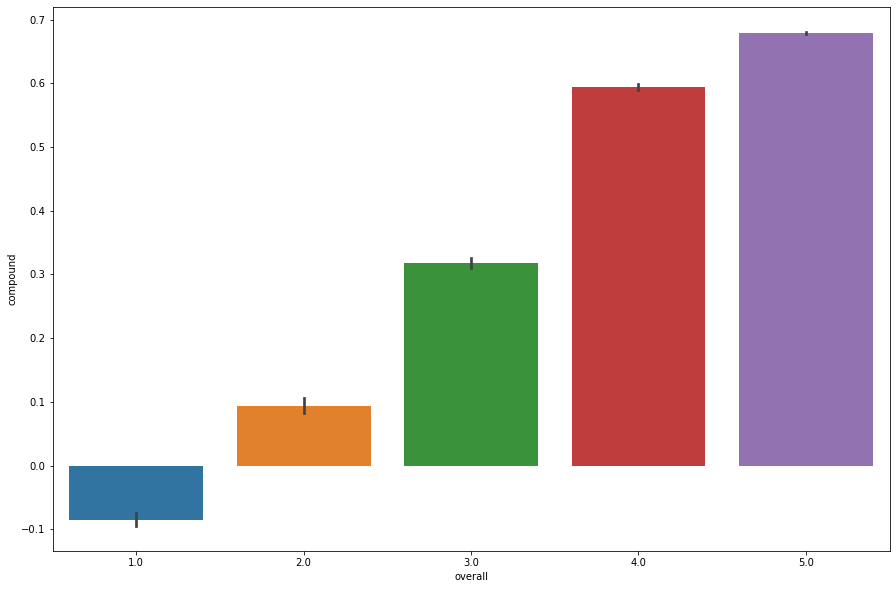

In [76]:
# Examining compund score vs star rating
fig, ax = plt.subplots(figsize = (15,10))
ax = sns.barplot(data = sent_val_df, x = 'overall', y = 'compound')

Above graph shows as star ratings increase positive sentiment also increases.

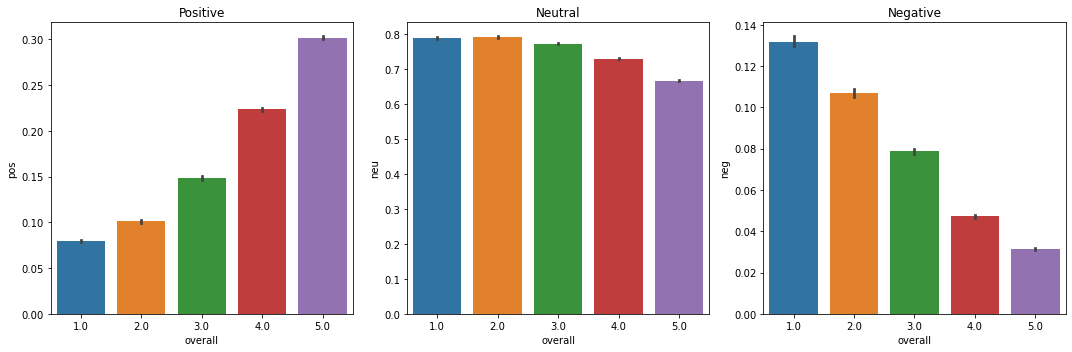

In [35]:
# Examine the positive, neutral, and negative scores vs star rating
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data = sent_val_df, x = 'overall', y = 'pos', ax = axs[0])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neu', ax = axs[1])
sns.barplot(data = sent_val_df, x = 'overall', y = 'neg', ax = axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
fig.tight_layout();

Positive sentiment score increases as star rating inscreases. Neutral score is relatively flat across star ratings. Negative score decreases as star rating increases. This confirms the connection between sentiment and star rating of reviews.

In [77]:
# Function to label star ratings above 3 to positive and ratings 3 or less to negative
def label_encode(x):
    if x <= 3:
        return 'Negative'
    if x > 3:
        return 'Positive'

In [78]:
df["sentiment"] = df["overall"].apply(lambda x: label_encode(x))

In [79]:
df['sentiment'].value_counts(normalize = True)

Positive    0.786164
Negative    0.213836
Name: sentiment, dtype: float64

Around 79% of reviews is positive and 21% negative. 

## Text Analysis

The main feature I will be working with will be reviewText. Upon some exploration of this feature, there is a high number of short text reviews. In order to get more information to work with I will combine the reviewText and summary features together.

In [39]:
df.reviewText[100]

'Very good headphones.'

In [40]:
df.summary[100]

'Five Stars'

In [41]:
df.reviewText[100] + " " + df.summary[100]

'Very good headphones. Five Stars'

In [81]:
# declare summary as text so it will not clear reviewText when combining with the 20 null values found in summary.
df['reviews'] = df.reviewText + ' ' + df.summary.astype(str)

I will now create some features to help examine some statistics of the text data, such as amounts of words and characters in reviews.

In [82]:
text_stats_df = df[['reviews', 'sentiment']].copy()

In [83]:
text_stats_df.head()

,reviews,sentiment
0,"Get the SportaPros instead. They look better,...",Positive
1,I've been looking for a lighter alternative to...,Positive
2,The finest headphones available. You can spend...,Positive
3,3rd pair of these I've purchased. My wife has...,Positive
4,My old Koss Porta Pros finally got beat to dea...,Positive


In [84]:
# Create functions to count the amount of words and characters in a review
def word_count(text):
    return len(word_tokenize(text))

def char_count(text):
    text_without_spaces = text.replace(" ", "")
    return len(text_without_spaces)

In [85]:
text_stats_df['word_count'] = df.reviews.apply(lambda x: word_count(x))
text_stats_df['review_len'] = df.reviews.apply(lambda x: char_count(x))

In [86]:
text_stats_df.head()

,reviews,sentiment,word_count,review_len
0,"Get the SportaPros instead. They look better,...",Positive,31,127
1,I've been looking for a lighter alternative to...,Positive,263,1097
2,The finest headphones available. You can spend...,Positive,119,512
3,3rd pair of these I've purchased. My wife has...,Positive,108,419
4,My old Koss Porta Pros finally got beat to dea...,Positive,170,713


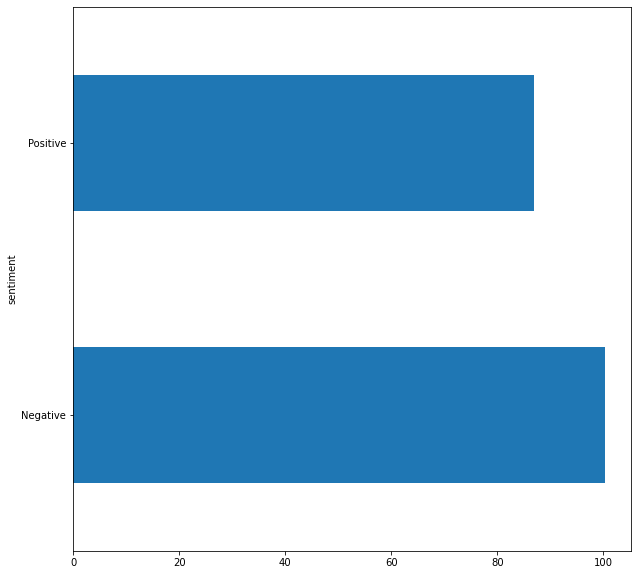

In [88]:
# Average word count of positive and negative reviews
text_stats_df.groupby('sentiment')['word_count'].mean().plot(kind = 'barh', figsize = (10,10));

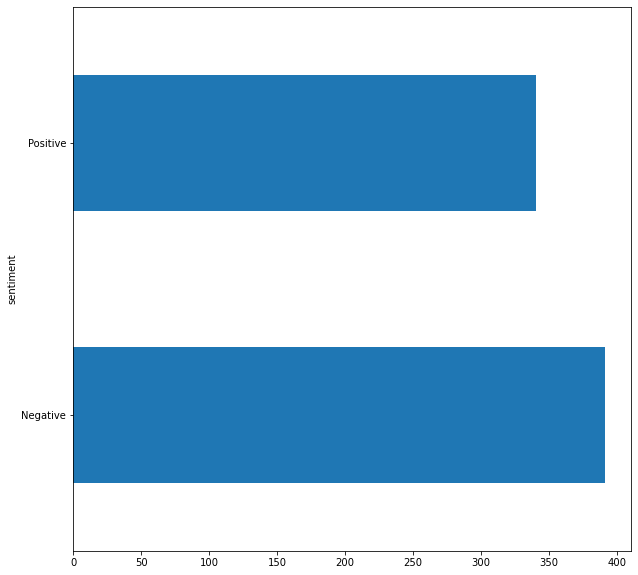

In [89]:
# Average review length of positive and negative reviews
text_stats_df.groupby('sentiment')['review_len'].mean().plot(kind = 'barh', figsize = (10,10));

Negative reviews tend to be slightly longer than positive reviews. This may explain that people are more descriptive when they feel negativley towards a product. The below correlation matrix confirms this, even though the correlation between word count, review length, and sentiment is small it is still negative.

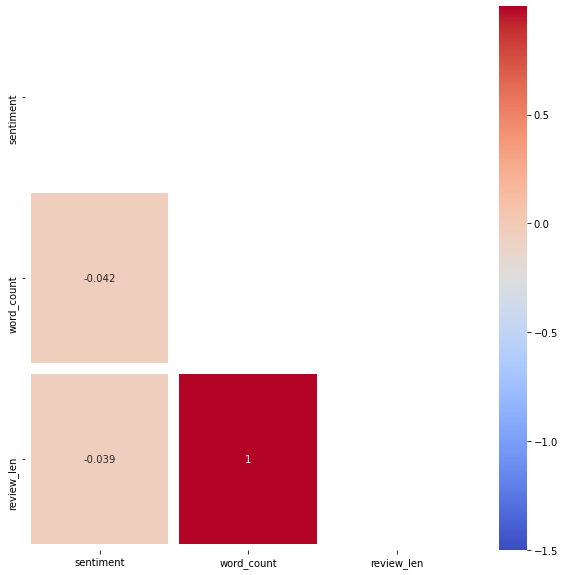

In [50]:
correlation = text_stats_df[['sentiment', 'word_count', 'review_len']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size": 10}, linewidths=10, vmin=-1.5, mask=mask);

In [90]:
text_stats_df.describe()

,word_count,review_len
count,189482.000000,189482.000000
mean,89.689163,351.412810
std,131.407122,521.631066
min,2.000000,4.000000
25%,22.000000,86.000000
50%,49.000000,192.000000
75%,105.000000,410.000000
max,4744.000000,19244.000000


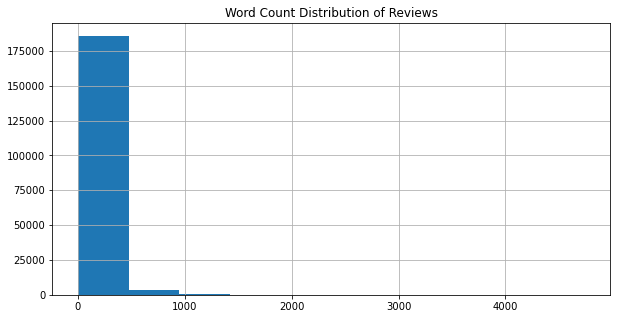

In [96]:
text_stats_df.word_count.hist(figsize = (10,5))
plt.title('Word Count Distribution of Reviews');

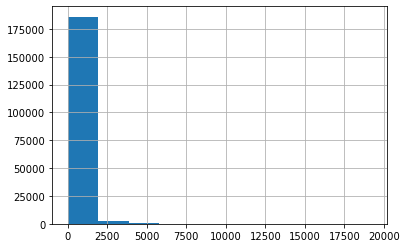

In [53]:
text_stats_df.review_len.hist();

Examining other statistics of word count and review length, I see most reviews are under 100 words and under around 400 characters.

In [54]:
text_stats_df.sort_values(by = 'word_count', ascending = False).head(20)

,reviews,sentiment,word_count,review_len
111300,UPDATE 12/12/15: Recently my Beats Studio Wire...,1,4744,19244
2772,If this is your first foray into high-end audi...,1,4014,16470
174311,"<div id=""video-block-R21WD3K0GDQSEG"" class=""a-...",1,3879,15043
97913,"Taking the Bose MIE2i, the most comfortable an...",1,3719,15626
169790,"Item arrived on time, well-packaged. Contained...",1,3256,12579
2854,I bought the HD600 refurbished from amazon.com...,1,3124,12914
134290,I've spent a long time in the following compar...,1,3043,11828
162588,I bought these headphones and they were my fir...,1,2991,13184
186975,Recently I went on search for noise cancellin...,1,2800,11228
111948,Compared the Audio Technica ANC7B's vs. Bose Q...,0,2786,10671


In [55]:
text_stats_df.sort_values(by = 'word_count', ascending = False).tail(20)

,reviews,sentiment,word_count,review_len
90444,Great Great,1,2,10
20214,Uncomfortable Uncomfortable,0,2,26
9199,works works,1,2,10
43149,Good Good,1,2,8
185135,great great,1,2,10
9282,A+ A+,1,2,4
90088,Thanks Thanks,1,2,12
90041,A1 A1,1,2,4
146848,Excellent Excellent,1,2,18
89995,Ok ok,1,2,4


### Text preprocessing

Examining some of the longest reviews, I can see that text the below steps are needed to clean text:

* Convert text to lowercase: This makes sure that the model does not treat the same word with different cases as different words.

* Remove punctuation: This step removes any special characters or punctuation marks that might not add much meaning to the text.

* Tokenize the text: Tokenization is the process of splitting the text into individual words or phrases. This is an important step as it allows us to analyze and manipulate individual words or phrases.

* Remove stop words: Stop words are commonly used words such as "the", "a", "an", "in", "and" that do not carry much meaning and can be removed.

* Remove numbers: If the numbers in the text do not add much value to the analysis, they can be removed.

* Stemming or Lemmatization: Stemming and Lemmatization are techniques used to reduce words to their root form so that variations of the same word can be treated as the same word.

* Remove HTML tags, URLs, line breaks, and extra spaces.

* Filter POS tags to include only nouns, verbs, adjectives, and adverbs.


In [56]:
# grab default stop words from spacy library
stop_words = nlp.Defaults.stop_words
len(stop_words)

326

In [57]:
def clean_text(text):
    # Replace &nbsp; with regular space
    text = text.replace("&nbsp;", " ")
    # Remove HTML tags and attributes
    text = re.sub(r"<[^>]+>", "", text)
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Remove line breaks and extra whitespace
    text = re.sub(r"\s+", " ", text)
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert to lowercase and remove leading/trailing white space tokenize and lemmatize
    doc = nlp(text)
    lemmas = [token.lemma_.lower().strip() for token in doc if not token.is_punct and not token.is_stop and len(token) > 2\
             and token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV']]

    return lemmas

In [58]:
text_stats_df.reviews[101837]

"It does what it says it does.  Transmission is a little weak, as obstacles (like people walking in front of it) tend to make it break up, but overall it's decent.  Probably not good for a party type situation.  I've only used as transmitter. Probably not good for a party type situation"

In [59]:
clean_text(text_stats_df.reviews[101837])

['say',
 'little',
 'weak',
 'obstacle',
 'people',
 'walk',
 'tend',
 'break',
 'overall',
 'decent',
 'probably',
 'good',
 'party',
 'type',
 'situation',
 'transmitter',
 'probably',
 'good',
 'party',
 'type',
 'situation']

In [60]:
text_stats_df['cleaned_text'] = text_stats_df.reviews.apply(lambda x: clean_text(x))

In [61]:
text_stats_df.head()

,reviews,sentiment,word_count,review_len,cleaned_text
0,"Get the SportaPros instead. They look better,...",1,31,127,"[instead, look, well, wear, street, configurat..."
1,I've been looking for a lighter alternative to...,1,263,1097,"[look, light, alternative, absolutely, perfect..."
2,The finest headphones available. You can spend...,1,119,512,"[fine, headphone, available, spend, vast, amou..."
3,3rd pair of these I've purchased. My wife has...,1,108,419,"[pair, purchase, wife, pair, pair, glove, box,..."
4,My old Koss Porta Pros finally got beat to dea...,1,170,713,"[old, finally, get, beat, death, year, ago, la..."


In [62]:
# New function to count tokens 
def word_count_tokened(text):
    return len(text)

def char_count_tokened(text):
    chars = sum(len(token) for token in text)
    return chars

In [63]:
text_stats_df['cleaned_word_count'] = text_stats_df.cleaned_text.apply(lambda x: word_count_tokened(x))
text_stats_df['cleaned_review_len'] = text_stats_df.cleaned_text.apply(lambda x: char_count_tokened(x))

In [64]:
text_stats_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len
count,189482.000000,189482.000000,189482.000000,189482.000000,189482.000000
mean,0.786164,89.689163,351.412810,30.438216,169.731252
std,0.410013,131.407122,521.631066,42.661517,245.995345
min,0.000000,2.000000,4.000000,0.000000,0.000000
25%,1.000000,22.000000,86.000000,8.000000,44.000000
50%,1.000000,49.000000,192.000000,18.000000,96.000000
75%,1.000000,105.000000,410.000000,36.000000,198.000000
max,1.000000,4744.000000,19244.000000,1642.000000,9301.000000


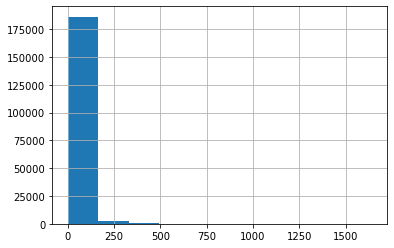

In [65]:
text_stats_df.cleaned_word_count.hist();

After cleaning text, some reviews now have 0 words.

In [55]:
text_stats_df[(text_stats_df.cleaned_word_count >= 10) & (text_stats_df.cleaned_word_count <= 200)]

NameError: name 'text_stats_df' is not defined

Outliers in text length can significantly affect the accuracy and reliability of sentiment analysis models. This is because longer texts may contain more nuanced and complex sentiments that are harder to detect automatically, while shorter texts may lack sufficient context and information for accurate sentiment analysis. Thus, including outliers in the analysis may lead to biased or noisy results that do not accurately reflect the overall sentiment of the dataset. I will choose to drop reviews with lower than 10 tokens and more than 200 tokens.

In [67]:
data_df = text_stats_df[(text_stats_df.cleaned_word_count >= 10) & (text_stats_df.cleaned_word_count <= 200)].copy()

In [68]:
data_df = data_df.reset_index(drop = True)

In [69]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133546 entries, 0 to 133545
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   reviews             133546 non-null  object
 1   sentiment           133546 non-null  int64 
 2   word_count          133546 non-null  int64 
 3   review_len          133546 non-null  int64 
 4   cleaned_text        133546 non-null  object
 5   cleaned_word_count  133546 non-null  int64 
 6   cleaned_review_len  133546 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 7.1+ MB


In [70]:
data_df.describe()

,sentiment,word_count,review_len,cleaned_word_count,cleaned_review_len
count,133546.000000,133546.000000,133546.000000,133546.000000,133546.000000
mean,0.766582,108.017238,421.973560,36.619127,203.925666
std,0.423007,97.712794,384.634014,31.455234,180.082586
min,0.000000,10.000000,46.000000,10.000000,34.000000
25%,1.000000,44.000000,172.000000,16.000000,87.000000
50%,1.000000,73.000000,283.000000,25.000000,139.000000
75%,1.000000,134.000000,520.000000,45.000000,250.000000
max,1.000000,841.000000,3646.000000,200.000000,1294.000000


<AxesSubplot:>

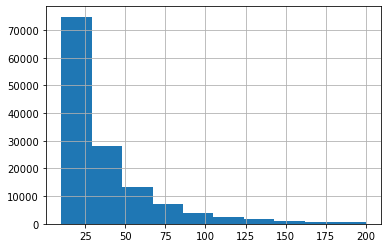

In [71]:
data_df.cleaned_word_count.hist()

In [72]:
data_df.sentiment.value_counts(normalize = True)

1    0.766582
0    0.233418
Name: sentiment, dtype: float64

### Word Frequency

Examining the most common unigrams, bigrams, and trigrams to find any words or phrases that may repeat across many documents.

In [34]:
# Create a dummy function to pass cleaned and tokenized text into count vectorizer
def dummy(doc):
    return doc

In [60]:
def top_words(text, n = None, ngram = (1,1)):
    # Function using count vectorizer to return top n frequent words
    cv = CountVectorizer(ngram_range = ngram, 
                         stop_words = None, 
                         tokenizer = dummy, 
                         preprocessor = dummy)
    words = cv.fit_transform(text)
    sum_words = words.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    word_df = pd.DataFrame(word_freq, columns=['word', 'count'])
    return word_df[:n]

#### Unigrams 

By examining the most common words we can get a sense of topics that may be most prominent. From the most common unigrams we can infer a couple topics will be about sound quality, comfort of product, and price.

In [61]:
top30 = top_words(text = data_df.cleaned_text, n = 30)

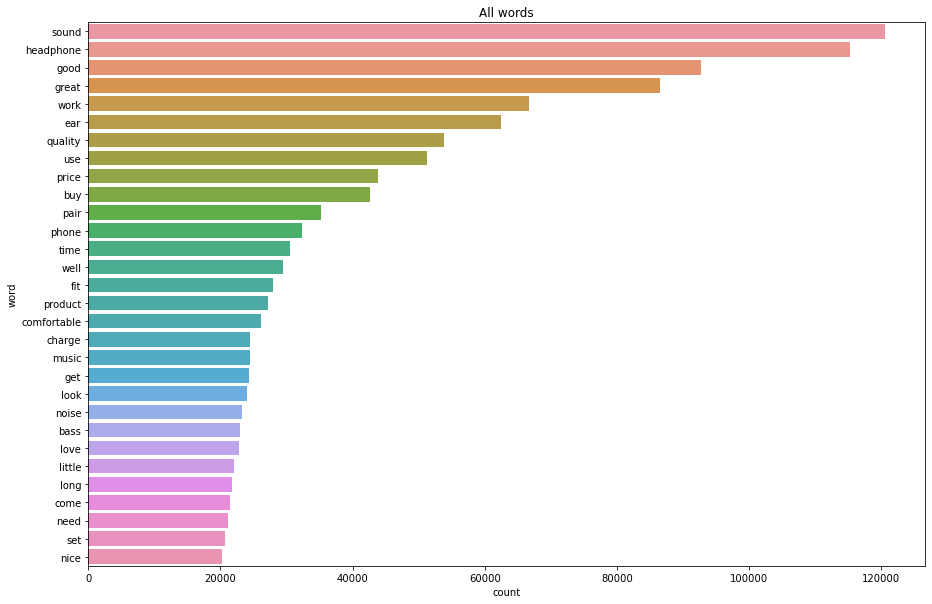

In [62]:
fig, axs = plt.subplots(figsize=(15,10))
sns.barplot(data = top30, x = 'count', y = 'word', orient = 'h', ax = axs)
axs.set_title('All words');

#### Bigrams

Examining bigram frequency could help us identify common phrases that customers use when describing the product. Important phrases found most common are sound quality, noise cancel, battery life, and customer service.

In [63]:
top30_bigrams = top_words(text = data_df.cleaned_text, n = 30, ngram = (2,2))

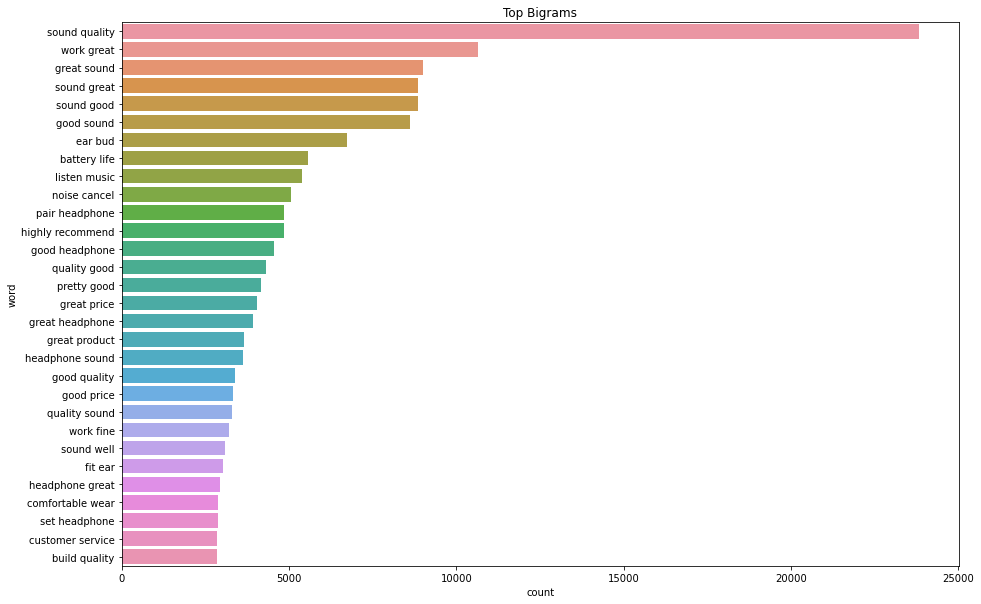

In [64]:
fig, axs = plt.subplots(figsize=(15,10))
sns.barplot(data = top30_bigrams, x = 'count', y = 'word', orient = 'h', ax = axs)
axs.set_title('Top Bigrams');

#### Trigrams

Trigrams do not seem to add any more information that is already given by unigrams and bigrams.

In [65]:
top30_trigrams = top_words(text = data_df.cleaned_text, n = 30, ngram = (3,3))

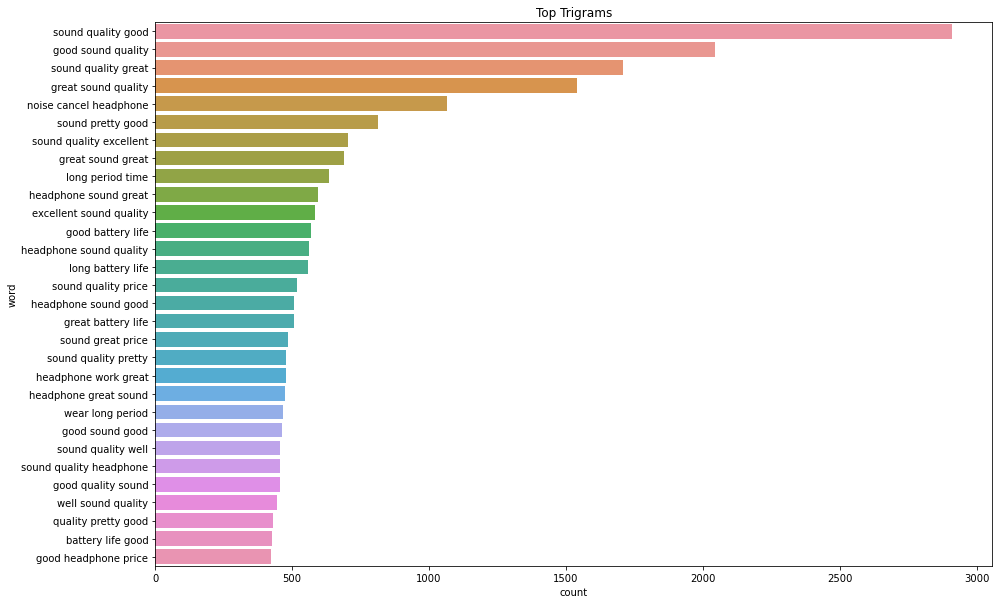

In [66]:
fig, axs = plt.subplots(figsize=(15,10))
sns.barplot(data = top30_trigrams, x = 'count', y = 'word', orient = 'h', ax = axs)
axs.set_title('Top Trigrams');

### Topic Modeling

In order to identify general themes customers are speaking about in the reviews, I will attempt to apply topic modeling on all the reviews.

LDA assumes that each document is a mixture of multiple topics and that each word in the document is associated with a particular topic. The model then attempts to identify the most likely topic distribution for each document and the most likely word distribution for each topic. I will be using Gensim's library to conduct LDA topic modeling.

In [97]:
data_words = data_df.cleaned_text

In [99]:
# Create bigrams
bigram = Phrases(data_words, min_count=10, threshold=0.7)
bigram_phraser = Phraser(bigram)
bigram_docs = [bigram_phraser[doc] for doc in data_words]


In [100]:
# create unique id for each token
id2word = corpora.Dictionary(bigram_docs)

# filter out rare and frequent tokens
id2word.filter_extremes(no_below = 10, no_above = 0.7)

# Create Corpus
texts = bigram_docs

# Create bag of words for LDA input
corpus = [id2word.doc2bow(text) for text in texts]

# View, each tuple represents words unique id and how many times they appear in the review
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [101]:
# run LdaMulticore for faster computation time
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         # start with a random number of topics
                         num_topics=6, 
                         random_state=100,
                         workers = 4,
                         chunksize=100,
                         passes=10,
                         alpha='symmetric')

In [102]:
lda_model.print_topics()

[(0,
  '0.042*"headset" + 0.019*"phone" + 0.017*"case" + 0.016*"good" + 0.013*"fit" + 0.013*"great" + 0.010*"run" + 0.009*"bluetooth" + 0.009*"like" + 0.009*"use"'),
 (1,
  '0.022*"work" + 0.020*"device" + 0.018*"use" + 0.014*"charge" + 0.010*"cable" + 0.010*"connect" + 0.010*"time" + 0.010*"battery" + 0.010*"need" + 0.009*"phone"'),
 (2,
  '0.076*"headphone" + 0.034*"sound" + 0.032*"good" + 0.023*"great" + 0.018*"price" + 0.017*"quality" + 0.016*"sound_quality" + 0.013*"bass" + 0.012*"comfortable" + 0.011*"music"'),
 (3,
  '0.030*"work" + 0.029*"great" + 0.023*"love" + 0.019*"buy" + 0.016*"product" + 0.014*"good" + 0.013*"work_great" + 0.013*"use" + 0.013*"pair" + 0.012*"month"'),
 (4,
  '0.022*"ear" + 0.022*"headphone" + 0.012*"earbud" + 0.011*"sound" + 0.010*"try" + 0.009*"work" + 0.007*"wear" + 0.007*"think" + 0.007*"time" + 0.007*"pair"'),
 (5,
  '0.013*"speaker" + 0.010*"product" + 0.008*"set" + 0.007*"audio" + 0.006*"keyboard" + 0.006*"bluetooth_headphone" + 0.006*"find" + 0.005

Above results show a list of topics, where each topic is represented as a tuple of (topic number, list of key terms and their weights).

In [103]:
# inspect first review
data_df.reviews[0]

'Get the SportaPros instead.  They look better, can be worn in a street configuration, cost less, and sound exactly the same. Get the SportaPros Instead.'

In [104]:
# LDA output for first review
lda_model[corpus][0]

[(0, 0.015243522),
 (1, 0.015220455),
 (2, 0.01539432),
 (3, 0.0152221825),
 (4, 0.7634709),
 (5, 0.17544864)]

According to our LDA model, the above text belongs to Topic 4 and 5. The article is 71% belonging to topic 4 and 22% belonging to topic 5. In order to evaulate our LDA model we can compute it's coherence score for reference.

In [105]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5150689805074576


Coherence metric is measure from 0 to 1, the higher the better. One way to determine optimal topic numbers would be to iterate over various topic numbers and compare their coherence score.

In [107]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, 
                             num_topics=num_topics, 
                             id2word=id2word, 
                             random_state=100,
                             workers = 4,
                             chunksize=100,
                             passes=10,
                             alpha='symmetric')
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [108]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=2, limit=26, step=3)

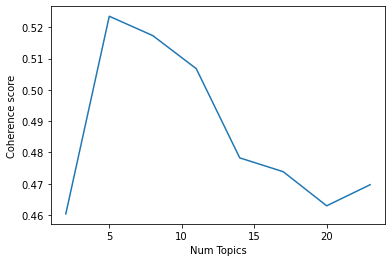

In [109]:
# plot of lda models by topic number and coherence score
limit=26; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score");

Originally num topics 8 had the higher coherence value, but LDA can have different results across different runs of the algorithm. The output is highly dependent on the initialization and randomness of the algorithm.

In [110]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4604
Num Topics = 5  has Coherence Value of 0.5235
Num Topics = 8  has Coherence Value of 0.5173
Num Topics = 11  has Coherence Value of 0.5068
Num Topics = 14  has Coherence Value of 0.4783
Num Topics = 17  has Coherence Value of 0.4739
Num Topics = 20  has Coherence Value of 0.463
Num Topics = 23  has Coherence Value of 0.4697


LDA model with 5 topics is shown to havethe highest coherence score.

In [111]:
# set optimal model to 8 topics
optimal_model = model_list[2]

pyLDAvis is an interactive visualization tool for exploring the topics learned by an LDA model. The visualizations generated by pyLDAvis can be used to gain insights into the topics and their relationships, as well as to evaluate the quality of the topics learned by the model.

In [112]:
# sort_topics set to False in order to keep topic numbering similar to LDA output.
# Visualization will start index at 1, where as LDA output will start topic index at 0.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word, sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.230995  0.054825       1        1   6.480038
1      0.002546 -0.042310       2        1  14.644197
2     -0.038789  0.123284       3        1  20.550719
3     -0.175143  0.016897       4        1   8.741840
4     -0.021132  0.087187       5        1  19.689230
5      0.331764  0.199957       6        1   6.999451
6      0.128005 -0.340703       7        1   7.238500
7      0.003744 -0.099137       8        1  15.656023, topic_info=          Term          Freq         Total Category  logprob  loglift
33   headphone  88521.000000  88521.000000  Default  30.0000  30.0000
105      great  47609.000000  47609.000000  Default  29.0000  29.0000
139    headset  19767.000000  19767.000000  Default  28.0000  28.0000
25         ear  25326.000000  25326.000000  Default  27.0000  27.0000
5        sound  40949.000000  40949.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
86        love   3811.910755  18299.084886   Topic8  -5.0554   0.2856
8         well   3733.592794  18196.342558   Topic8  -5.0762   0.2705
260        use   3803.623569  29912.694626   Topic8  -5.0576  -0.2080
223       come   3175.396598  14209.453898   Topic8  -5.2381   0.3558
137       good   3847.529979  50693.424844   Topic8  -5.0461  -0.7241

[528 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1655      8  0.998898         abuse
6946      7  0.873437     accessory
6946      8  0.125623     accessory
3522      5  0.997849  active_noise
2045      2  0.901794       adapter
...     ...       ...           ...
2574      8  0.033460       workout
68        3  0.104168          year
68        8  0.895683          year
2164      4  0.526453      year_old
2164      8  0.473149      year_old

[948 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

Upon examining visualization from lda model with topic number set to 8, it can be observed that there are a number of topics found that are clustered together. A large number of topics are also found in a similar quadrant. From these results I can infer that even though coherence value is slightly higher compared to LDA model with 5 topics, it may not be as easily interpretable. I will check the visualization for 5 topics.

In [113]:
lda_5_model = model_list[1]

In [114]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_5_model, corpus, id2word, sort_topics = False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.273817 -0.019598       1        1  15.700727
1      0.041877 -0.195788       2        1  18.320153
2     -0.052168  0.197821       3        1  24.093313
3     -0.233112 -0.120472       4        1  14.438381
4     -0.030414  0.138036       5        1  27.447426, topic_info=          Term          Freq         Total Category  logprob  loglift
33   headphone  85595.000000  85595.000000  Default  30.0000  30.0000
5        sound  42079.000000  42079.000000  Default  29.0000  29.0000
25         ear  23323.000000  23323.000000  Default  28.0000  28.0000
254       work  38065.000000  38065.000000  Default  27.0000  27.0000
629    product  15734.000000  15734.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
187       time   5991.960120  19481.668815   Topic5  -5.1646   0.1138
55     quality   5873.980746  18625.063172   Topic5  -5.1844   0.1389
8         well   5836.951825  18417.507693   Topic5  -5.1908   0.1438
86        love   5449.160878  16964.232613   Topic5  -5.2595   0.1573
16         buy   5428.417632  23718.232355   Topic5  -5.2633  -0.1817

[358 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2045      2  0.999520         adapter
12        1  0.001011         amazing
12        3  0.777607         amazing
12        4  0.189011         amazing
12        5  0.032176         amazing
...     ...       ...             ...
2084      2  0.999790  work_perfectly
2574      5  0.999833         workout
68        3  0.153455            year
68        4  0.616609            year
68        5  0.229855            year

[602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [115]:
#pyLDAvis.save_html(vis, 'pyldavis_output.html')

In [117]:
#lda_5_model.save('lda_model')

From examining the keywords from each topic from visualization, I came to the below conclusions for topic labels.

* Topic 1: Design
* Topic 2: Battery / Connectivity
* Topic 3: Sound Quality
* Topic 4: Customer Service
* Topic 5: Comfort

These results are much better compared to model with 8 topics. Topic clusters are more spread out in different quadrants. There is some overlap with topics 3 and 5, which may be due to common words describing sound quality and comfort.

In [117]:
# Adding dominant topic to the data
dominant_topics = []
# loop through results of LDA model to retrieve topic with the highest contribution of the document
for i in range(len(corpus)):
    topic_weights = lda_5_model[corpus[i]]
    dominant_topic = max(topic_weights, key=lambda x: x[1])
    dominant_topics.append(dominant_topic[0])    
data_df['dominant_topic'] = dominant_topics

In [119]:
data_df.head()

,reviews,sentiment,word_count,review_len,cleaned_text,cleaned_word_count,cleaned_review_len,dominant_topic
0,"Get the SportaPros instead. They look better,...",1,31,127,"[instead, look, well, wear, street, configurat...",10,61,4
1,I've been looking for a lighter alternative to...,1,263,1097,"[look, light, alternative, absolutely, perfect...",92,563,2
2,The finest headphones available. You can spend...,1,119,512,"[fine, headphone, available, spend, vast, amou...",48,287,2
3,3rd pair of these I've purchased. My wife has...,1,108,419,"[pair, purchase, wife, pair, pair, glove, box,...",36,195,3
4,My old Koss Porta Pros finally got beat to dea...,1,170,713,"[old, finally, get, beat, death, year, ago, la...",65,367,4


In [15]:
# Applying label names previously discovered
new_labels = {0:'Design', 1:'Battery / Connectivity', 2:'Sound Quality', 3:'Customer Service', 4:'Comfort'}
data_df.replace({'dominant_topic':new_labels}, inplace = True)

In [16]:
data_df.dominant_topic.value_counts(normalize = True)

Comfort                   0.340235
Sound Quality             0.258810
Battery / Connectivity    0.177250
Customer Service          0.117944
Design                    0.105761
Name: dominant_topic, dtype: float64

Most talked about topic is Comfort with 34% of reviews belonging to this topic. Least talked about is Design at around 10% of reviews making up this topic. 

In [137]:
# Creating function to inspect the sentiment of topics found.
def plot_features(feature, order = None, data = data_df, fname = False):
    if order != None:
        data[feature] = pd.Categorical(data[feature], categories = order, ordered = True)
        df_grouped = data.groupby(feature)['sentiment'].value_counts(normalize = True).unstack('sentiment')
    else:
        df_grouped = data.groupby(feature)['sentiment'].value_counts(normalize=True).unstack('sentiment').sort_values('Positive')

    fig, ax = plt.subplots()    
    
    df_grouped.index.name = None
    df_grouped.columns.name = None
    df_swap = df_grouped[['Positive', 'Negative']]
    
    df_swap.plot.barh(figsize = (15,10), stacked = True, ax = ax);
    
    for rect in ax.patches:
        # find where each bar is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
    
        # The height of the bar is the data value and can be used as the label
        label_text = f'{(width*100):.1f}%'  # format text to show only 1 decimal place in percentage
    
        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
    
        # only plot labels greater than given width
        if width > 0.05:
            ax.text(label_x, label_y, label_text, ha='center', va='center',\
                    fontsize=15)

    # move the legend
    ax.legend(bbox_to_anchor=(0.5, 1),
            loc="lower center",
            borderaxespad=0,
            frameon=False,
            ncol=2)

    ax.xaxis.set_ticklabels([])
    
    # save file to images folder if specified
    if fname:
        fig.savefig(('images/' + fname), dpi=200, bbox_inches = 'tight')

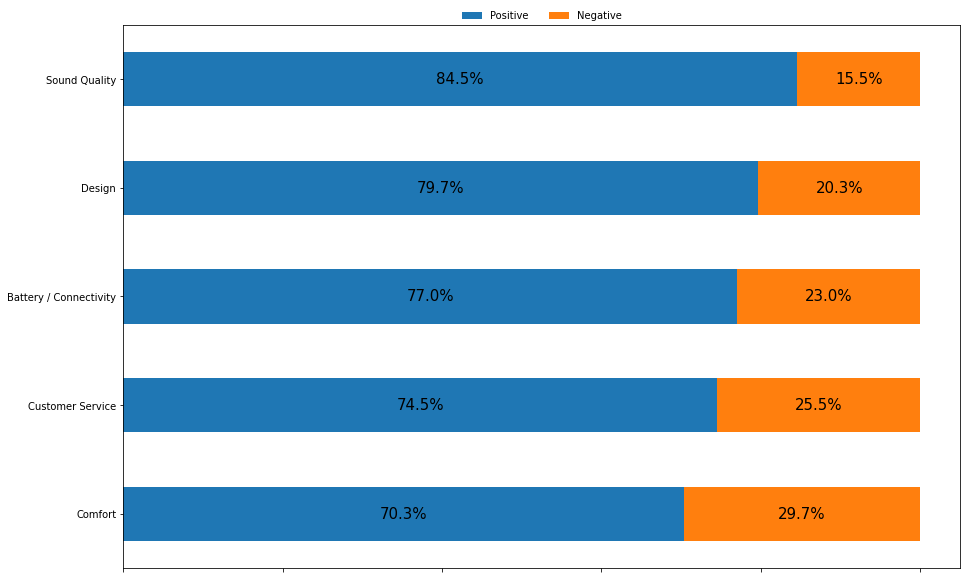

In [96]:
plot_features('dominant_topic')

Topic with this most positive sentiment was found to be Sound Quality. The topic with the least positive sentiment is Comfort.

In [124]:
data_df.drop(columns = ['word_count', 'review_len', 'cleaned_word_count', 'cleaned_review_len'], inplace = True)

In [4]:
data_df.head()

,reviews,sentiment,cleaned_text,dominant_topic
0,"Get the SportaPros instead. They look better,...",1,"[instead, look, well, wear, street, configurat...",4
1,I've been looking for a lighter alternative to...,1,"[look, light, alternative, absolutely, perfect...",2
2,The finest headphones available. You can spend...,1,"[fine, headphone, available, spend, vast, amou...",2
3,3rd pair of these I've purchased. My wife has...,1,"[pair, purchase, wife, pair, pair, glove, box,...",3
4,My old Koss Porta Pros finally got beat to dea...,1,"[old, finally, get, beat, death, year, ago, la...",4


In [126]:
data_df.to_csv('data/processed_reviews.csv', index = False)

In [33]:
data_df = pd.read_csv('data/processed_reviews.csv', converters = {'cleaned_text': literal_eval})